In [506]:
import cv2
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [507]:
class Ellipse:
    def __init__(self, image_size=256, short_axis_min=100, long_axis_min=250, noise_diameter_max=30):
        self.image_size = image_size
        self.short_axis_min = short_axis_min
        self.long_axis_min = long_axis_min
        self.noise_diameter_max = noise_diameter_max
        
        self.ellipse, self.noisy_ellipse = self.generate_ellipse_with_noise()
    
    def generate_ellipse_with_noise(self):
        image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        
        center = (self.image_size // 2, self.image_size // 2)
        short_axis = random.randint(self.short_axis_min // 2, self.image_size // 2)
        long_axis = min(random.randint(self.long_axis_min, self.image_size), short_axis * 3)
        
        ellipse_image = cv2.ellipse(image.copy(), center, (long_axis, short_axis), 0, 0, 360, 1, -1)
        
        noisy_image = self.add_noise(ellipse_image)
        
        return ellipse_image, noisy_image
    
    def add_noise(self, image):
        noisy_image = image.copy()
        
        num_noises = random.randint(5, 15)
        
        for _ in range(num_noises):
            x = random.randint(0, self.image_size - 1)
            y = random.randint(0, self.image_size - 1)
            diameter = random.randint(5, self.noise_diameter_max)
            
            cv2.circle(noisy_image, (x, y), diameter // 2, 0, -1)
            
        return noisy_image

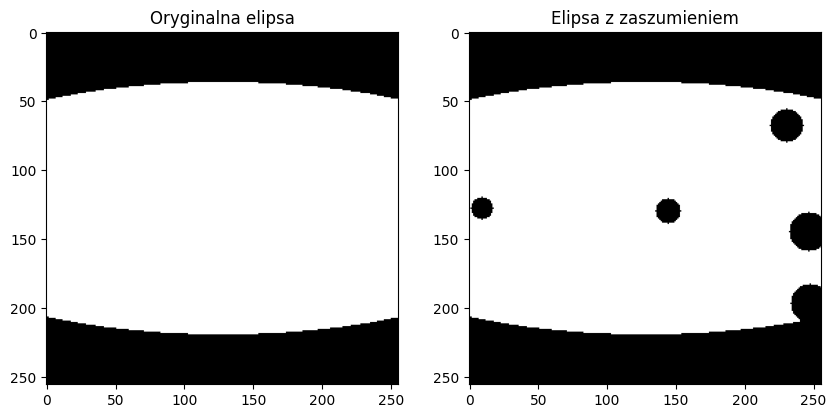

In [508]:
ellipse = Ellipse()

# Wyświetlanie obrazów oryginalnego i zaszumionego
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Oryginalna elipsa")
plt.imshow(ellipse.ellipse, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Elipsa z zaszumieniem")
plt.imshow(ellipse.noisy_ellipse, cmap='gray')
plt.show()

In [509]:
class EllipseDataset:
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.ellipses = [Ellipse().ellipse for _ in range(num_samples)]
        self.noisy_ellipses = [Ellipse().noisy_ellipse for _ in range(num_samples)]
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.ellipses[idx]

In [510]:
from keras.src.layers import Conv2DTranspose
from keras.src.losses import losses

dataset = EllipseDataset(1000)


class Autoencoder(Model):
    def __init__(self, input_shape=(256, 256, 1)):
        super(Autoencoder, self).__init__()
        # Encoder
        self.input_img = Input(shape=input_shape)
        self.encoder = keras.Sequential([
            Input(shape=input_shape),
            Conv2D(128, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(32, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')
        ])
    
        # Decoder
        self.decoder = keras.Sequential([
            Conv2DTranspose(32, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(128, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

autoencoder.summary()

Model: "autoencoder_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_111 (Sequential)     │ ?                      │       105,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_112 (Sequential)     │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,760 (413.12 KB)

 Trainable params: 105,760 (413.12 KB)

 Non-trainable params: 0 (0.00 B)

In [511]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="checkpoints/model_at_epoch_{epoch}.keras"),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=5, mode="min", restore_best_weights=True)
]

history = autoencoder.fit(x= np.array(dataset.noisy_ellipses).reshape(-1, 256, 256, 1), y= np.array(dataset.ellipses).reshape(-1, 256, 256, 1), epochs=25, batch_size=64, callbacks=callbacks, validation_split=0.2)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 0.2081 - mean_squared_error: 0.2081 - val_loss: 0.1665 - val_mean_squared_error: 0.1665
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1584 - val_mean_squared_error: 0.1584
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.1582 - mean_squared_error: 0.1582 - val_loss: 0.1482 - val_mean_squared_error: 0.1482
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.1495 - mean_squared_error: 0.1495 - val_loss: 0.1453 - val_mean_squared_error: 0.1453
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - loss: 0.1419 - mean_squared_error: 0.1419 - val_loss: 0.1437 - val_mean_squared_error: 0.1437
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.1462 - mean_squared_error: 0.1462 - val_loss: 0.1418 - val_mean_squared_error: 0.1418
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - loss: 0.1445 - mean_squared_error: 0.1445 - val_loss: 0.1451 - val_mean_

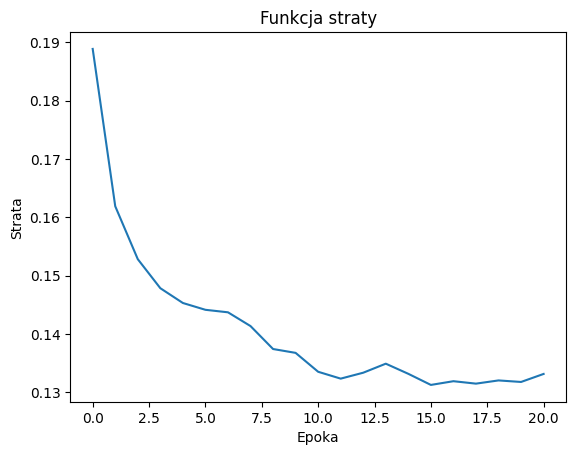

In [512]:
plt.plot(history.history['loss'])
plt.title('Funkcja straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


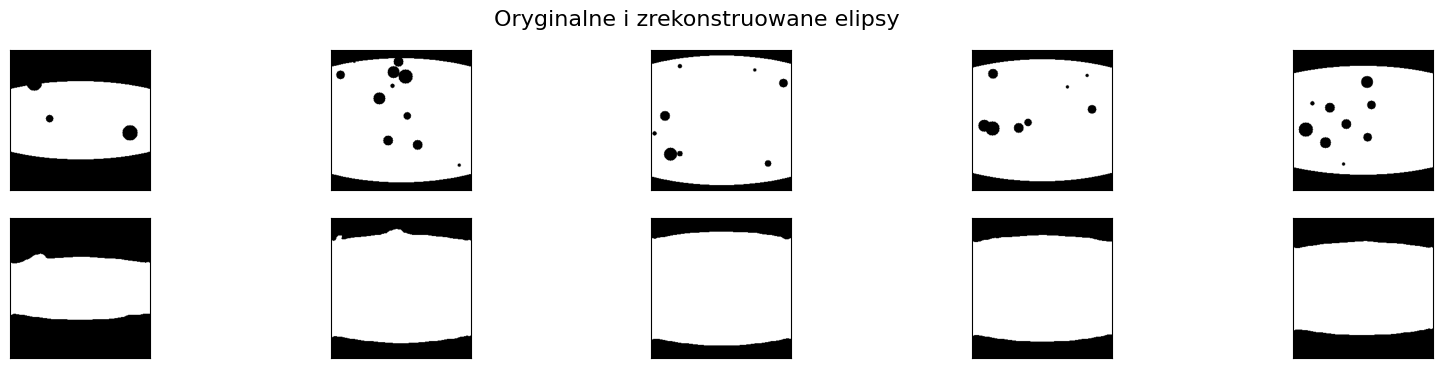

In [527]:
def plot_results(images, title, n_images=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    for i in range(n_images):
        # Display original images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    for i in range(n_images):
        # Display reconstructed images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        image = autoencoder.predict(images[i].reshape(1, 256, 256, 1)).reshape(256, 256)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image = cv2.medianBlur(image, 5)
        # binarize image
        _, image = cv2.threshold(image, 195, 255, cv2.THRESH_BINARY)
        plt.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
    
plot_results(np.array(dataset.noisy_ellipses), "Oryginalne i zrekonstruowane elipsy")